## Import Library and Utility Function


In [ ]:
import os
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import matplotlib.pyplot as plt

# Fungsi untuk memuat kata-kata dari file
def load_words(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        words = file.read().splitlines()
    return words

# Fungsi untuk memuat kata-kata slang
def load_slang_words(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        slang_dict = json.loads(file.read())
    return slang_dict

# Fungsi untuk membaca file teks dari folder
def read_text_files(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                content = file.read().strip()
                if content:  # Check if the file is not empty
                    cleaned_content = clean_text(content)
                    texts.append(cleaned_content)
    return texts

# Fungsi untuk membaca file sampling
def read_sampling_files(folder_path, num_files=100):
    texts = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith(".txt")]
    sampled_filenames = filenames[:num_files]  # Ambil hanya sejumlah file yang diperlukan
    for filename in sampled_filenames:
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            content = file.read().strip()
            if content:  # Check if the file is not empty
                cleaned_content = clean_text(content)
                texts.append(cleaned_content)
    return texts


# Fungsi untuk membersihkan teks
def clean_text(text):
    unwanted_chars = ['*', '#', '_', ')', '(', '!', '?', '.', ',', '-']
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

## Configure GPU

In [ ]:
# Konfigurasi Memori GPU dan Mixed Precision Training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])  # Set memory limit to 2GB
    except RuntimeError as e:
        print(e)

from tensorflow.keras.mixed_precision import Policy, set_global_policy
policy = Policy('mixed_float16')
set_global_policy(policy)

## Load Data

In [36]:
# Memuat data untuk dataset 1 (kosakata)
root_words = load_words('../Dataset/indonesian_word/combined_root_words.txt')
stop_words = load_words('../Dataset/indonesian_word/combined_stop_words.txt')
slang_dict = load_slang_words('../Dataset/indonesian_word/combined_slang_words.txt')

# Gabungkan semua kata untuk pembentukan kosakata
all_words = list(set(root_words + stop_words + list(slang_dict.keys()) + list(slang_dict.values())))

# Memuat dataset 2 (paragraf tentang Python)
dataset2_texts = read_text_files('../Dataset/nlp_dataset')

# Memuat dataset 2 dengan metode sampling
dataset2_sampling = read_sampling_files('../Dataset/nlp_dataset', num_files=1)


In [37]:
# Menghitung dan mencetak jumlah kata dalam dataset 2
total_words_dataset2 = sum(len(text.split()) for text in dataset2_texts)
print(f'Total jumlah kata dalam dataset 2: {total_words_dataset2}')


Total jumlah kata dalam dataset 2: 1089130


In [38]:
# mencetak jumlah kata dalam sampling
total_words_dataset_sampling = sum(len(text.split()) for text in dataset2_sampling)
print(f'Total jumlah kata dalam dataset sampling: {total_words_dataset_sampling}')

Total jumlah kata dalam dataset sampling: 1039


## Data Prepeare

In [39]:
# Tokenizer untuk dataset 1
tokenizer = Tokenizer(num_words=len(all_words), oov_token='<OOV>')
tokenizer.fit_on_texts(all_words)

# Tokenisasi dan padding untuk dataset 1
dataset1_sequences = tokenizer.texts_to_sequences(all_words)
dataset1_padded = pad_sequences(dataset1_sequences, padding='post')

# Dataset dan target untuk pelatihan
dataset1_inputs = dataset1_padded[:, :-1]
dataset1_targets = dataset1_padded[:, 1:]

# Create a dataset from the input and target sequences
train_dataset1 = tf.data.Dataset.from_tensor_slices((dataset1_inputs, dataset1_targets))
train_dataset1 = train_dataset1.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


## Arsitektur words model


In [40]:
# Hyperparameters
embedding_dim = 64
lstm_units = 128
vocab_size = len(all_words)  # Adjust based on your vocabulary size

# Input Layer
inputs = Input(shape=(None,), name="inputs")

# Embedding Layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding_layer")(inputs)

# LSTM Layer
lstm_output = LSTM(lstm_units, return_sequences=True, name="lstm_layer")(embedding)

# Output Layer for Vocabulary Understanding
outputs = Dense(vocab_size, activation='softmax', name="output_layer")(lstm_output)

# Model
vocab_model = Model(inputs=inputs, outputs=outputs, name="vocab_model")

# Compile Model with mixed precision optimizer
optimizer = Adam()
vocab_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Summary
vocab_model.summary()


Model: "vocab_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None)]            0         
                                                                 
 embedding_layer (Embedding)  (None, None, 64)         1897152   
                                                                 
 lstm_layer (LSTM)           (None, None, 128)         98816     
                                                                 
 output_layer (Dense)        (None, None, 29643)       3823947   
                                                                 
Total params: 5,819,915
Trainable params: 5,819,915
Non-trainable params: 0
_________________________________________________________________


## Train Words model

In [41]:
# Pelatihan Model Kosakata dengan Gradient Accumulation
accumulation_steps = 4

@tf.function
def train_step_vocabulary(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = vocab_model(inputs, training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(targets, predictions)
    scaled_loss = loss / accumulation_steps
    gradients = tape.gradient(scaled_loss, vocab_model.trainable_variables)
    return gradients, loss

for epoch in range(10):
    print(f'Epoch {epoch + 1}/{10}')
    accum_gradients = [tf.zeros_like(var, dtype=tf.float32) for var in vocab_model.trainable_variables]
    for step, (inputs, targets) in enumerate(train_dataset1):
        gradients, loss = train_step_vocabulary(inputs, targets)
        accum_gradients = [
            accum_grad + (grad if grad is not None else tf.zeros_like(accum_grad))
            for accum_grad, grad in zip(accum_gradients, gradients)
        ]
        
        if (step + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(accum_gradients, vocab_model.trainable_variables))
            accum_gradients = [tf.zeros_like(var, dtype=tf.float32) for var in vocab_model.trainable_variables]
    
    if step % accumulation_steps != 0:
        optimizer.apply_gradients(zip(accum_gradients, vocab_model.trainable_variables))
    
    print(f'Loss: {loss.numpy().mean()}')

vocab_model.save_weights('../saved_model/base_model_saved/base_model_04/vocab_model_weights.h5')

Epoch 1/10
Loss: 10.296875
Epoch 2/10
Loss: 10.296875
Epoch 3/10
Loss: 10.296875
Epoch 4/10
Loss: 10.296875
Epoch 5/10
Loss: 10.296875
Epoch 6/10
Loss: 10.296875
Epoch 7/10
Loss: 10.296875
Epoch 8/10
Loss: 10.296875
Epoch 9/10
Loss: 10.296875
Epoch 10/10
Loss: 10.296875


## Arsitektur Self-Attention Model

In [42]:
# Buat optimizer baru
optimizer = Adam(learning_rate=0.001)

# Bungkus optimizer dengan LossScaleOptimizer hanya jika belum dibungkus
if not getattr(optimizer, '_is_wrapped_by_loss_scale_optimizer', False):
    optimizer = mixed_precision.LossScaleOptimizer(optimizer, loss_scale='dynamic')

# Arsitektur Model Self-Attention
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding_layer")
embedding_layer.build((None,))
embedding_layer.set_weights(vocab_model.get_layer('embedding_layer').get_weights())

def transformer_layer(x, d_model, num_heads, dff, rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    ffn_output = tf.keras.Sequential([
        Dense(dff, activation='relu'), 
        Dense(d_model)])(out1)
    
    ffn_output = Dropout(rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    return out2

num_transformer_layers = 1  # Mengurangi jumlah layer Transformer
num_heads = 2  # Mengurangi jumlah heads
dff = 128  # Mengurangi dimensi feed-forward

inputs = Input(shape=(None,), name="inputs")
embedding = embedding_layer(inputs)

transformer_output = embedding
for _ in range(num_transformer_layers):
    transformer_output = transformer_layer(transformer_output, embedding_dim, num_heads, dff)

outputs = Dense(vocab_size, activation='softmax', name="output_layer")(transformer_output)

context_model = Model(inputs=inputs, outputs=outputs, name="context_model")
context_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
context_model.summary()

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)
Model: "context_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, None, 64)     1897152     ['inputs[0][0]']                 
                                                                                                  
 multi_head_attention_1 (MultiH  (None, None, 64)    33216       ['embedding_layer[0][0]',        
 eadAttention)                                                    'embedding_layer[0][0]']        
                                                                                                  
 dropout_2 (Dropout)         

## Dataset 2 Prep

In [43]:
# Persiapan Data untuk Dataset 2
dataset2_sequences = tokenizer.texts_to_sequences(dataset2_sampling)
dataset2_padded = pad_sequences(dataset2_sequences, padding='post')

dataset2_inputs = dataset2_padded[:, :-1]
dataset2_targets = dataset2_padded[:, 1:]

train_dataset2 = tf.data.Dataset.from_tensor_slices((dataset2_inputs, dataset2_targets))
train_dataset2 = train_dataset2.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


## Training Model Self-Attention


In [44]:
# Pelatihan Model Self-Attention dengan Gradient Accumulation
accumulation_steps = 4

@tf.function
def train_step_attention(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = context_model(inputs, training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(targets, predictions)
    scaled_loss = loss / accumulation_steps
    gradients = tape.gradient(scaled_loss, context_model.trainable_variables)
    return gradients, loss

history_context = {
    'loss': [],
    'accuracy': []
}

num_epoch = 1000

for epoch in range(num_epoch):
    print(f'Epoch {epoch + 1}/{num_epoch}')
    accum_gradients = [tf.zeros_like(var, dtype=tf.float32) for var in context_model.trainable_variables]
    epoch_loss = []
    epoch_accuracy = []
    
    for step, (inputs, targets) in enumerate(train_dataset2):
        gradients, loss = train_step_attention(inputs, targets)
        accum_gradients = [
            accum_grad + (grad if grad is not None else tf.zeros_like(accum_grad))
            for accum_grad, grad in zip(accum_gradients, gradients)
        ]
        
        if (step + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(accum_gradients, context_model.trainable_variables))
            accum_gradients = [tf.zeros_like(var, dtype=tf.float32) for var in context_model.trainable_variables]
        
        epoch_loss.append(loss.numpy().mean())
        epoch_accuracy.append(context_model.evaluate(train_dataset2, verbose=0)[1])
    
    if step % accumulation_steps != 0:
        optimizer.apply_gradients(zip(accum_gradients, context_model.trainable_variables))
    
    history_context['loss'].append(np.mean(epoch_loss))
    history_context['accuracy'].append(np.mean(epoch_accuracy))
    print(f'Loss: {np.mean(epoch_loss)}, Accuracy: {np.mean(epoch_accuracy)}')

context_model.save_weights('../saved_model/base_model_saved/base_model_04/context_model_weights.h5')

Epoch 1/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 2/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 3/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 4/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 5/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 6/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 7/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 8/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 9/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 10/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 11/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 12/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 13/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 14/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 15/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 16/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 17/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 18/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 19/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 20/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 21/1000
Loss: 10.3046875, Accuracy: 0.0
Epoch 22/1000
Loss: 10.3046875, Accuracy: 0

In [45]:
# Muat model dari path yang telah disimpan
context_model.load_weights('../saved_model/base_model_saved/base_model_04/context_model_weights.h5')

# Fungsi untuk menghitung perplexity
def perplexity(y_true, y_pred):
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    perplexity = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity

# Fungsi untuk visualisasi loss dan accuracy
def plot_metrics(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{title} - Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')
    
    plt.show()

# Fungsi untuk mengevaluasi model dan visualisasi hasil
def evaluate_model(model, dataset, title):
    results = model.evaluate(dataset)
    print(f'{title} - Evaluation Results:')
    print(f'Loss: {results[0]:.20f}')
    print(f'Accuracy: {results[1]:.20f}')
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_pred = model.predict(dataset)
    print(f'Perplexity: {perplexity(y_true, y_pred).numpy():.10f}')

In [46]:
# Evaluasi model context
evaluate_model(context_model, train_dataset2, 'Context Model')


1/1 [==============================] - 0s 36ms/step - loss: 10.3047 - accuracy: 0.0000e+00
Context Model - Evaluation Results:
Loss: 10.30468750000000000000
Accuracy: 0.00000000000000000000
Perplexity: 29872.0000000000


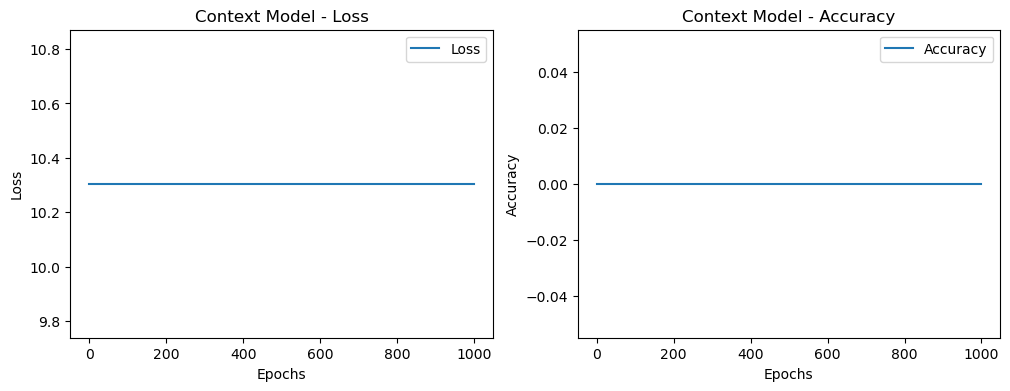

In [47]:
# Plot metrics untuk context_model
plot_metrics(history_context, 'Context Model')

In [48]:
def generate_text(model, start_string, num_generate=100):
    input_eval = [tokenizer.word_index[s] for s in start_string.split() if s in tokenizer.word_index]
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = []
    model.reset_states()
    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        
        if predicted_id in tokenizer.index_word:
            text_generated.append(tokenizer.index_word[predicted_id])
        else:
            text_generated.append("<UNK>")  # Tambahkan token untuk kata yang tidak dikenal
    
    return start_string + ' ' + ' '.join(text_generated)

# generasi teks
print(generate_text(context_model, start_string="pada suatu hari"))


pada suatu hari kilo temaha kooperator maritim rasanya binal ungkal raharja lenggut cuil katalog homoiotermal distabilitas gertik iritasi dialektika metalurgis kapitulasi stabilizer libra sadur ameliorasi keok rahimakallah empok <UNK> mengkona kuricak diptotos lot rante yaumulkiamah mampung retardasi nonproduktif emoh malafide bindu amatlah kecelakaan mancur antonimi gender lara kelewang mangan dapa stokastik amfiteater protuberansia rasian ram homosfer penelitian testamen asetat monokotiledon modifikasi ketang suprafiks ideologis intensif gompal gebu walau kardil mujtahid kecu tem termolabil berebes kendayakan homolog konspirasi alferes coang liman cacil viaduk keletung candik logo jendul otda asdsadsada elektrolisis hidroponik tafeta cuk dekung banang tribunal ceding parampara gosan irigator mei kelebat tarzan cekeram
